In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt     #2D图库

import torchvision.transforms as transforms
import torchvision.models as models

import copy


#分配cpu，在没有gpu的情况下
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 期望输出图片的大小，统一输入的尺寸
#imsize_w 和imsize_h是设置导入图片的宽和高
imsize_w = 512 if torch.cuda.is_available() else 256  # use small size if no gpu
imsize_h = 200


loader = transforms.Compose([
    transforms.Resize((imsize_w,imsize_h)),  # 调整输入图片的尺寸
    transforms.ToTensor()])  # 将图片转成torch中的tensor类，基本数据单元，张量


# 加载图片
def image_loader(image_name):
    image = Image.open(image_name)
    #调整批量维度
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


#style是风格图片，content是转换图片
#图片需在images目录下
style_img = image_loader("./images/style.jpg")
content_img = image_loader("./images/test.jpg")


#判断图片是否是一样的尺寸
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


######################################################################
#函数作用，使图片副本变成PIL格式
#显示图像使用plt.imshow()


unloader = transforms.ToPILImage()  # 重新转成PIL图像

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 复制一个clone副本
    image = image.squeeze(0)      # 移除加入的批量纬度
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 暂停以更新图表


#显示风格图片和原始图片，可以测试是否显示
#plt.figure()
#imshow(style_img, title='Style Image')

#plt.figure()
#imshow(content_img, title='Content Image')


######################################################################
#内容损失函数
#从动态计算梯度过程中分离目标模块，使丢失层透明
#将损失值作为返回的模块参数

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


######################################################################
#风格损失
#该函数是对风格矩阵中要素图的归一化，先形成gram矩阵，逐渐梯度下降
def gram_matrix(input):
    a, b, c, d = input.size()  # a是batch size，一般是1
    # b是要素图的数量
    # (c,d)=f的尺寸维度. map (N=c*d)

    features = input.view(a * b, c * d)  # 重新规划F F_XL -> /hat F_XL

    G = torch.mm(features, features.t())  # 计算gram矩阵
    return G.div(a * b * c * d)


#风格损失函数主体，和内容损失一致
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


######################################################################
# 导入模型
# 这里是使用训练好的19层VGG
# 第一次使用会自动下载

cnn = models.vgg19(pretrained=True).features.to(device).eval()



######################################################################
# VGG网络图像上的训练
# 每个信道通过均值= [0.485,0.456,0.406]和std = [0.229,0.224,0.225]归一化。
# 标准化图像，然后再将其发送到网络中。



cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# 创建一个模块来规范化输入图像以便用nn.Sequential使用
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        #view函数的作用时其设置的标准化
        #以便使用tensor[B*C*H*W].B batch size.C通道数，H高度，W宽度
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        #标准化图片
        return (img - self.mean) / self.std



#创建一个新Sequential 模块，其中正确插入了内容丢失和样式丢失模块。
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # 标准化模块
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 拥有可迭代访问的列表内容，获取风格图片和输入图片的损失值
    content_losses = []
    style_losses = []

    # 创建新的nn.Sequential放入按顺序激活的模块
    model = nn.Sequential(normalization)

    i = 0  # 转换增量
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            #这里替换掉不合适的损失值
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 添加内容图片损失
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # 添加风格图片损失
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 找到loss后面的一层记录位置，在网络中插入loss,去掉后面的layers。
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


######################################################################
#输入图片
input_img = content_img.clone()

#显示inputimage，测试
#plt.figure()
#imshow(input_img, title='Input Image')


######################################################################
# 梯度下降函数

def get_input_optimizer(input_img):
    # L-BFGS算法运行梯度下降。创建优化器。
    #将图像作为张量进行优化。
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


######################################################################
# 执行神经传递的函数，对于网络的每次迭代，反馈更新损失值。
# backward是动态的计算梯度。
# num_steps 越大，训练越久

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            #更正输入图像的值
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后的更正
    input_img.data.clamp_(0, 1)

    return input_img


######################################################################
#运行

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 158.902985 Content Loss: 39.814617

run [100]:
Style Loss : 49.435379 Content Loss: 36.904377

run [150]:
Style Loss : 16.438551 Content Loss: 33.741772

run [200]:
Style Loss : 8.304040 Content Loss: 30.184423

run [250]:
Style Loss : 5.514135 Content Loss: 26.998690

run [300]:
Style Loss : 4.141501 Content Loss: 24.776289



KeyboardInterrupt: 

In [6]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            #更正输入图像的值
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后的更正
    input_img.data.clamp_(0, 1)

    return input_img



Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.904005 Content Loss: 19.544033

run [100]:
Style Loss : 1.867065 Content Loss: 19.335327

run [150]:
Style Loss : 1.832594 Content Loss: 19.152973

run [200]:
Style Loss : 1.788285 Content Loss: 18.983601

run [250]:
Style Loss : 1.755809 Content Loss: 18.831940

run [300]:
Style Loss : 1.720065 Content Loss: 18.700958



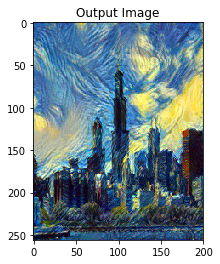

In [8]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()